# Prerequisites

## Install Library

In [49]:
# for python 3.12.3
%pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import Library

In [50]:
## Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import datetime as dt
from tqdm import tqdm
import optuna
from scipy.stats import randint, uniform
from skopt import BayesSearchCV
from scipy.stats import skew, normaltest, zscore
from geopy.distance import geodesic
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid, RandomizedSearchCV, ParameterSampler, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_curve, ConfusionMatrixDisplay, average_precision_score, cohen_kappa_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import json
import joblib
import warnings
warnings.filterwarnings("ignore")

## Read Data

In [51]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTrain_cleaned.csv", index_col=0)

In [52]:
# Convert trans_date_trans_time to datetime
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

In [53]:
df.head()

,trans_date_trans_time,cc_num,merchant,amt,first,last,gender,street,city,state,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,2019-01-01 00:00:18,2703186189652095,514,4.97,Jennifer,Banks,0,561 Perry Cove,526,27,...,0,0,0,1,0,0,0,0,0,78.773821
1,2019-01-01 00:00:44,630423337322,241,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,612,47,...,0,0,0,0,0,0,0,0,0,30.216618
2,2019-01-01 00:00:51,38859492057661,390,220.11,Edward,Sanchez,1,594 White Dale Suite 530,468,13,...,0,0,0,0,0,0,0,0,0,108.102912
3,2019-01-01 00:01:16,3534093764340240,360,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,84,26,...,0,0,0,0,0,0,0,0,0,95.685115
4,2019-01-01 00:03:06,375534208663984,297,41.96,Tyler,Garcia,1,408 Bradley Rest,216,45,...,0,0,0,0,1,0,0,0,0,77.702395


In [54]:
df.columns

Index(['trans_date_trans_time', 'cc_num', 'merchant', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud', 'age', 'hour', 'day', 'month', 'year', 'is_weekend',
       'is_weekday', 'time_diff', 'diff_days', 'diff_hours', 'diff_minutes',
       'diff_seconds', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel', 'distance'],
      dtype='object')

In [55]:
df.dtypes

trans_date_trans_time      datetime64[ns]
cc_num                              int64
merchant                            int64
amt                               float64
first                              object
last                               object
gender                              int64
street                             object
city                                int64
state                               int64
zip                                 int64
lat                               float64
long                              float64
city_pop                            int64
job                                 int64
dob                                object
trans_num                          object
unix_time                           int64
merch_lat                         float64
merch_long                        float64
is_fraud                            int64
age                                 int64
hour                                int64
day                               

In [56]:
df.isnull().sum()

trans_date_trans_time      0
cc_num                     0
merchant                   0
amt                        0
first                      0
last                       0
gender                     0
street                     0
city                       0
state                      0
zip                        0
lat                        0
long                       0
city_pop                   0
job                        0
dob                        0
trans_num                  0
unix_time                  0
merch_lat                  0
merch_long                 0
is_fraud                   0
age                        0
hour                       0
day                        0
month                      0
year                       0
is_weekend                 0
is_weekday                 0
time_diff                  0
diff_days                  0
diff_hours                 0
diff_minutes               0
diff_seconds               0
category_entertainment     0
category_food_

In [57]:
df_all = df.copy()

# Standard 70/20/10 train/validation/test split
# First split: 70% train, 30% temp (which will be split into 20% val, 10% test)
X_temp = df_all.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'is_fraud'], axis=1)
y_temp = df_all['is_fraud']

X_train, X_temp, y_train, y_temp = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, stratify=y_temp
)

# Second split: 20% validation, 10% test (from the 30% temp)
# 20/30 = 0.667 for validation, 10/30 = 0.333 for test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp
)

# Get corresponding dataframes for later use
train_indices = X_train.index
val_indices = X_val.index
test_indices = X_test.index

df_train_final = df_all.loc[train_indices]
df_val = df_all.loc[val_indices]
df_test = df_all.loc[test_indices]

In [58]:
print("=== Standard 70/20/10 Split Information ===")
print(f"Training set: {len(df_train_final):,} samples ({len(df_train_final)/len(df_all)*100:.1f}%)")
print(f"Validation set: {len(df_val):,} samples ({len(df_val)/len(df_all)*100:.1f}%)")
print(f"Test set: {len(df_test):,} samples ({len(df_test)/len(df_all)*100:.1f}%)")
print(f"Total: {len(df_all):,} samples")

print("\n=== Fraud Distribution by Set ===")
print(f"Training set fraud rate: {df_train_final['is_fraud'].mean()*100:.2f}%")
print(f"Validation set fraud rate: {df_val['is_fraud'].mean()*100:.2f}%")
print(f"Test set fraud rate: {df_test['is_fraud'].mean()*100:.2f}%")
print(f"Overall fraud rate: {df_all['is_fraud'].mean()*100:.2f}%")

=== Standard 70/20/10 Split Information ===
Training set: 907,672 samples (70.0%)
Validation set: 259,465 samples (20.0%)
Test set: 129,538 samples (10.0%)
Total: 1,296,675 samples

=== Fraud Distribution by Set ===
Training set fraud rate: 0.58%
Validation set fraud rate: 0.58%
Test set fraud rate: 0.58%
Overall fraud rate: 0.58%


In [59]:
df_train_final.shape, df_val.shape, df_test.shape

((907672, 48), (259465, 48), (129538, 48))

# Model Pipeline

## 1. Features

### 1.1 Split Features and Target

In [60]:
columns_to_exclude = ['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num']

# Train
X_train = df_train_final.drop(columns_to_exclude, axis=1)
y_train = df_train_final["is_fraud"]

# Validation
X_val = df_val.drop(columns_to_exclude, axis=1)
y_val = df_val["is_fraud"]

# Test
X_test = df_test.drop(columns_to_exclude, axis=1)
y_test = df_test["is_fraud"]

### 1.2 Feature Scaling

In [61]:
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

### 1.3 Feature Selection

In [62]:
# 1st: Select K Best (Find the 10 best features)
# Feature selection
selector = SelectKBest(score_func=f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

Result from SelectKBest

In [63]:
# List the selected features from SelectKBest
selected_features = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_features]
print("Selected Features:", selected_feature_names)

Selected Features: Index(['amt', 'time_diff', 'diff_hours', 'diff_seconds',
       'category_food_dining', 'category_grocery_pos', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_shopping_net'],
      dtype='object')


In [64]:
# 2nd: PCA (Dimensionality Reduction)
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_selected)
X_val_pca = pca.transform(X_val_selected)
X_test_pca = pca.transform(X_test_selected)

In [65]:
# Define the model pipeline
model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=10)),
    ('pca', PCA(n_components=5)),
    ('isolation_forest', IsolationForest(random_state=42))
])

model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('select_kbest', SelectKBest()),
                ('pca', PCA(n_components=5)),
                ('isolation_forest', IsolationForest(random_state=42))])

## 2. Isolation Forest

### 2.1 Find Best Parameters

#### Bayesian Optimization with Optuna

In [ ]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    max_samples = trial.suggest_categorical('max_samples', ['auto', 0.8])
    contamination = trial.suggest_float('contamination', 0.001, 0.02)
    max_features = trial.suggest_categorical('max_features', [1.0, 0.8])

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('select_kbest', SelectKBest(score_func=f_classif, k=15)),
        ('pca', PCA(n_components=8)),
        ('isolation_forest', IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=42
        ))
    ])

    # Train on train set
    pipeline.fit(X_train, y_train)
    # Predict on validation set
    y_pred = pipeline.predict(X_val)
    # IsolationForest: -1 = anomaly, 1 = normal
    y_pred_bin = (y_pred == -1).astype(int)

    print("y_val unique:", np.unique(y_val))
    print("y_pred_bin unique:", np.unique(y_pred_bin))

     # Calculate metrics
    f1 = f1_score(y_val, y_pred_bin, average='binary')
    recall = recall_score(y_val, y_pred_bin, average='binary')
    precision = precision_score(y_val, y_pred_bin, average='binary')
    pr_auc = average_precision_score(y_val, y_pred_bin)
    kappa = cohen_kappa_score(y_val, y_pred_bin)

    # Log metrics to Optuna
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("pr_auc", pr_auc)
    trial.set_user_attr("kappa", kappa)    # Print metrics (optional)
    print(f"F1: {f1:.3f}, Recall: {recall:.3f}, Precision: {precision:.3f}, PR-AUC: {pr_auc:.3f}, Kappa: {kappa:.3f}")

    # Return precision score (เน้น Precision สูง)
    return precision_score(y_val, y_pred_bin, average='binary', zero_division=0)

In [ ]:
# Run Optuna for High Precision
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best params from Optuna (Precision-focused):", study.best_params)
print("Best Precision Score:", study.best_value)

[I 2025-07-31 00:53:54,341] A new study created in memory with name: no-name-ef40e523-6e59-40bd-8202-baf46ac3caa1


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.007, Recall: 0.005, Precision: 0.012, PR-AUC: 0.006, Kappa: 0.003


[I 2025-07-31 00:55:51,405] Trial 0 finished with value: 0.011864406779661017 and parameters: {'n_estimators': 275, 'max_samples': 0.8, 'contamination': 0.002083759490112102, 'max_features': 1.0}. Best is trial 0 with value: 0.011864406779661017.
[I 2025-07-31 00:56:01,974] Trial 1 finished with value: 0.00907617504051864 and parameters: {'n_estimators': 150, 'max_samples': 'auto', 'contamination': 0.0118393261792878, 'max_features': 1.0}. Best is trial 0 with value: 0.011864406779661017.
[I 2025-07-31 00:56:01,974] Trial 1 finished with value: 0.00907617504051864 and parameters: {'n_estimators': 150, 'max_samples': 'auto', 'contamination': 0.0118393261792878, 'max_features': 1.0}. Best is trial 0 with value: 0.011864406779661017.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.012, Recall: 0.019, Precision: 0.009, PR-AUC: 0.006, Kappa: 0.004
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.007, Recall: 0.005, Precision: 0.012, PR-AUC: 0.006, Kappa: 0.004
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.007, Recall: 0.005, Precision: 0.012, PR-AUC: 0.006, Kappa: 0.004


[I 2025-07-31 00:57:20,550] Trial 2 finished with value: 0.012345679012345678 and parameters: {'n_estimators': 195, 'max_samples': 0.8, 'contamination': 0.0020118012368547595, 'max_features': 1.0}. Best is trial 2 with value: 0.012345679012345678.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.104, Recall: 0.182, Precision: 0.072, PR-AUC: 0.018, Kappa: 0.096


[I 2025-07-31 00:58:18,111] Trial 3 finished with value: 0.07235621521335807 and parameters: {'n_estimators': 133, 'max_samples': 0.8, 'contamination': 0.0141253652611487, 'max_features': 1.0}. Best is trial 3 with value: 0.07235621521335807.
[I 2025-07-31 00:58:38,101] Trial 4 finished with value: 0.034518396031417944 and parameters: {'n_estimators': 231, 'max_samples': 'auto', 'contamination': 0.01830554750300652, 'max_features': 0.8}. Best is trial 3 with value: 0.07235621521335807.
[I 2025-07-31 00:58:38,101] Trial 4 finished with value: 0.034518396031417944 and parameters: {'n_estimators': 231, 'max_samples': 'auto', 'contamination': 0.01830554750300652, 'max_features': 0.8}. Best is trial 3 with value: 0.07235621521335807.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.053, Recall: 0.111, Precision: 0.035, PR-AUC: 0.009, Kappa: 0.044


[I 2025-07-31 00:58:52,933] Trial 5 finished with value: 0.0019011406844106464 and parameters: {'n_estimators': 225, 'max_samples': 'auto', 'contamination': 0.001913010612395345, 'max_features': 1.0}. Best is trial 3 with value: 0.07235621521335807.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.001, Recall: 0.001, Precision: 0.002, PR-AUC: 0.006, Kappa: -0.002


[I 2025-07-31 00:59:15,280] Trial 6 finished with value: 0.037665886026541764 and parameters: {'n_estimators': 269, 'max_samples': 'auto', 'contamination': 0.019398804017827682, 'max_features': 0.8}. Best is trial 3 with value: 0.07235621521335807.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.058, Recall: 0.128, Precision: 0.038, PR-AUC: 0.010, Kappa: 0.050
y_val unique: [0 1]
y_pred_bin unique: [0 1]
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.107, Recall: 0.231, Precision: 0.069, PR-AUC: 0.021, Kappa: 0.099
F1: 0.107, Recall: 0.231, Precision: 0.069, PR-AUC: 0.021, Kappa: 0.099


[I 2025-07-31 01:01:24,493] Trial 7 finished with value: 0.06948338005606729 and parameters: {'n_estimators': 287, 'max_samples': 0.8, 'contamination': 0.018831257362705398, 'max_features': 0.8}. Best is trial 3 with value: 0.07235621521335807.
[I 2025-07-31 01:02:16,167] Trial 8 finished with value: 0.07387247278382582 and parameters: {'n_estimators': 120, 'max_samples': 0.8, 'contamination': 0.019291556166861984, 'max_features': 0.8}. Best is trial 8 with value: 0.07387247278382582.
[I 2025-07-31 01:02:16,167] Trial 8 finished with value: 0.07387247278382582 and parameters: {'n_estimators': 120, 'max_samples': 0.8, 'contamination': 0.019291556166861984, 'max_features': 0.8}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.114, Recall: 0.253, Precision: 0.074, PR-AUC: 0.023, Kappa: 0.106


[I 2025-07-31 01:02:31,236] Trial 9 finished with value: 0.004649000464900047 and parameters: {'n_estimators': 225, 'max_samples': 'auto', 'contamination': 0.008001571952946453, 'max_features': 1.0}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.005, Recall: 0.007, Precision: 0.005, PR-AUC: 0.006, Kappa: -0.001


[I 2025-07-31 01:03:13,183] Trial 10 finished with value: 0.0420997920997921 and parameters: {'n_estimators': 104, 'max_samples': 0.8, 'contamination': 0.007018359647393899, 'max_features': 0.8}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.047, Recall: 0.054, Precision: 0.042, PR-AUC: 0.008, Kappa: 0.041


[I 2025-07-31 01:03:53,964] Trial 11 finished with value: 0.07003298655163664 and parameters: {'n_estimators': 101, 'max_samples': 0.8, 'contamination': 0.014866455569538207, 'max_features': 0.8}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.101, Recall: 0.184, Precision: 0.070, PR-AUC: 0.018, Kappa: 0.094


[I 2025-07-31 01:04:55,607] Trial 12 finished with value: 0.06417395916202599 and parameters: {'n_estimators': 144, 'max_samples': 0.8, 'contamination': 0.014259075307464711, 'max_features': 0.8}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.092, Recall: 0.161, Precision: 0.064, PR-AUC: 0.015, Kappa: 0.084


[I 2025-07-31 01:05:59,005] Trial 13 finished with value: 0.07119821384271893 and parameters: {'n_estimators': 153, 'max_samples': 0.8, 'contamination': 0.015050567401049637, 'max_features': 1.0}. Best is trial 8 with value: 0.07387247278382582.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.104, Recall: 0.191, Precision: 0.071, PR-AUC: 0.018, Kappa: 0.096


[I 2025-07-31 01:06:50,922] Trial 14 finished with value: 0.07446083995459706 and parameters: {'n_estimators': 129, 'max_samples': 0.8, 'contamination': 0.016462988285317382, 'max_features': 1.0}. Best is trial 14 with value: 0.07446083995459706.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.111, Recall: 0.218, Precision: 0.074, PR-AUC: 0.021, Kappa: 0.103
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.095, Recall: 0.188, Precision: 0.064, PR-AUC: 0.017, Kappa: 0.088
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.095, Recall: 0.188, Precision: 0.064, PR-AUC: 0.017, Kappa: 0.088


[I 2025-07-31 01:08:03,805] Trial 15 finished with value: 0.06394035246272028 and parameters: {'n_estimators': 182, 'max_samples': 0.8, 'contamination': 0.01683336028033008, 'max_features': 0.8}. Best is trial 14 with value: 0.07446083995459706.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.083, Recall: 0.125, Precision: 0.062, PR-AUC: 0.013, Kappa: 0.076


[I 2025-07-31 01:08:52,567] Trial 16 finished with value: 0.06237491661107405 and parameters: {'n_estimators': 121, 'max_samples': 0.8, 'contamination': 0.01120570125949815, 'max_features': 1.0}. Best is trial 14 with value: 0.07446083995459706.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.096, Recall: 0.191, Precision: 0.065, PR-AUC: 0.017, Kappa: 0.089


[I 2025-07-31 01:10:06,147] Trial 17 finished with value: 0.06450887839964037 and parameters: {'n_estimators': 178, 'max_samples': 0.8, 'contamination': 0.016845241097773037, 'max_features': 0.8}. Best is trial 14 with value: 0.07446083995459706.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.270, Precision: 0.076, PR-AUC: 0.025, Kappa: 0.111


[I 2025-07-31 01:11:15,479] Trial 18 finished with value: 0.07595884003741815 and parameters: {'n_estimators': 167, 'max_samples': 0.8, 'contamination': 0.01987540528044732, 'max_features': 1.0}. Best is trial 18 with value: 0.07595884003741815.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.067, Recall: 0.089, Precision: 0.054, PR-AUC: 0.010, Kappa: 0.061


[I 2025-07-31 01:12:20,077] Trial 19 finished with value: 0.054285714285714284 and parameters: {'n_estimators': 164, 'max_samples': 0.8, 'contamination': 0.008996863532893364, 'max_features': 1.0}. Best is trial 18 with value: 0.07595884003741815.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.243, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 01:13:42,375] Trial 20 finished with value: 0.07993867717915024 and parameters: {'n_estimators': 200, 'max_samples': 0.8, 'contamination': 0.017057801900498885, 'max_features': 1.0}. Best is trial 20 with value: 0.07993867717915024.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.241, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.112


[I 2025-07-31 01:15:06,462] Trial 21 finished with value: 0.0800530738611234 and parameters: {'n_estimators': 207, 'max_samples': 0.8, 'contamination': 0.016931890250176312, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.103, Recall: 0.170, Precision: 0.074, PR-AUC: 0.017, Kappa: 0.096


[I 2025-07-31 01:16:35,269] Trial 22 finished with value: 0.07412790697674419 and parameters: {'n_estimators': 211, 'max_samples': 0.8, 'contamination': 0.012830083731886684, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.240, Precision: 0.077, PR-AUC: 0.023, Kappa: 0.109


[I 2025-07-31 01:18:11,388] Trial 23 finished with value: 0.07702154896522295 and parameters: {'n_estimators': 242, 'max_samples': 0.8, 'contamination': 0.01760832735662971, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.116, Recall: 0.232, Precision: 0.077, PR-AUC: 0.022, Kappa: 0.108


[I 2025-07-31 01:19:51,853] Trial 24 finished with value: 0.07700794351279788 and parameters: {'n_estimators': 251, 'max_samples': 0.8, 'contamination': 0.017027656582174866, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.096, Recall: 0.160, Precision: 0.069, PR-AUC: 0.016, Kappa: 0.089


[I 2025-07-31 01:21:32,760] Trial 25 finished with value: 0.0685127033970882 and parameters: {'n_estimators': 245, 'max_samples': 0.8, 'contamination': 0.013110467844458504, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.
[I 2025-07-31 01:21:46,325] Trial 26 finished with value: 0.004208754208754209 and parameters: {'n_estimators': 196, 'max_samples': 'auto', 'contamination': 0.004357598746941505, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.
[I 2025-07-31 01:21:46,325] Trial 26 finished with value: 0.004208754208754209 and parameters: {'n_estimators': 196, 'max_samples': 'auto', 'contamination': 0.004357598746941505, 'max_features': 1.0}. Best is trial 21 with value: 0.0800530738611234.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.004, Recall: 0.003, Precision: 0.004, PR-AUC: 0.006, Kappa: -0.001
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.227, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.227, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111


[I 2025-07-31 01:23:10,136] Trial 27 finished with value: 0.08015984955336154 and parameters: {'n_estimators': 209, 'max_samples': 0.8, 'contamination': 0.015956923367186935, 'max_features': 1.0}. Best is trial 27 with value: 0.08015984955336154.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.223, Precision: 0.081, PR-AUC: 0.023, Kappa: 0.111


[I 2025-07-31 01:24:35,958] Trial 28 finished with value: 0.08095698405026583 and parameters: {'n_estimators': 210, 'max_samples': 0.8, 'contamination': 0.01557460076830542, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.083, Recall: 0.117, Precision: 0.064, PR-AUC: 0.013, Kappa: 0.076


[I 2025-07-31 01:26:05,090] Trial 29 finished with value: 0.06418672501823487 and parameters: {'n_estimators': 212, 'max_samples': 0.8, 'contamination': 0.010122426755894316, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:27:29,381] Trial 30 finished with value: 0.08022922636103152 and parameters: {'n_estimators': 214, 'max_samples': 0.8, 'contamination': 0.015738630292373032, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:27:29,381] Trial 30 finished with value: 0.08022922636103152 and parameters: {'n_estimators': 214, 'max_samples': 0.8, 'contamination': 0.015738630292373032, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.224, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.222, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.222, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110


[I 2025-07-31 01:28:53,488] Trial 31 finished with value: 0.07963757749165475 and parameters: {'n_estimators': 212, 'max_samples': 0.8, 'contamination': 0.015733555805048254, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.094, Recall: 0.155, Precision: 0.068, PR-AUC: 0.015, Kappa: 0.087


[I 2025-07-31 01:30:42,321] Trial 32 finished with value: 0.06761462565293093 and parameters: {'n_estimators': 263, 'max_samples': 0.8, 'contamination': 0.012970302523076734, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:31:53,744] Trial 33 finished with value: 0.08048722235490804 and parameters: {'n_estimators': 180, 'max_samples': 0.8, 'contamination': 0.015699294129315235, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:31:53,744] Trial 33 finished with value: 0.08048722235490804 and parameters: {'n_estimators': 180, 'max_samples': 0.8, 'contamination': 0.015699294129315235, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.224, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.218, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.218, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110


[I 2025-07-31 01:33:07,935] Trial 34 finished with value: 0.08021521154316459 and parameters: {'n_estimators': 186, 'max_samples': 0.8, 'contamination': 0.015304259717463593, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:33:19,868] Trial 35 finished with value: 0.006603773584905661 and parameters: {'n_estimators': 174, 'max_samples': 'auto', 'contamination': 0.012198765796053041, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:33:19,868] Trial 35 finished with value: 0.006603773584905661 and parameters: {'n_estimators': 174, 'max_samples': 'auto', 'contamination': 0.012198765796053041, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.009, Recall: 0.014, Precision: 0.007, PR-AUC: 0.006, Kappa: 0.001
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.110, Recall: 0.191, Precision: 0.077, PR-AUC: 0.019, Kappa: 0.102
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.110, Recall: 0.191, Precision: 0.077, PR-AUC: 0.019, Kappa: 0.102


[I 2025-07-31 01:34:35,129] Trial 36 finished with value: 0.0770883695944131 and parameters: {'n_estimators': 189, 'max_samples': 0.8, 'contamination': 0.013903564608384336, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:34:48,187] Trial 37 finished with value: 0.010837229069273268 and parameters: {'n_estimators': 187, 'max_samples': 'auto', 'contamination': 0.018105234239487143, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:34:48,187] Trial 37 finished with value: 0.010837229069273268 and parameters: {'n_estimators': 187, 'max_samples': 'auto', 'contamination': 0.018105234239487143, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.016, Recall: 0.034, Precision: 0.011, PR-AUC: 0.006, Kappa: 0.008
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.111, Recall: 0.204, Precision: 0.076, PR-AUC: 0.020, Kappa: 0.103
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.111, Recall: 0.204, Precision: 0.076, PR-AUC: 0.020, Kappa: 0.103


[I 2025-07-31 01:36:24,258] Trial 38 finished with value: 0.07615976184569585 and parameters: {'n_estimators': 232, 'max_samples': 0.8, 'contamination': 0.015214357857667178, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.098, Recall: 0.170, Precision: 0.069, PR-AUC: 0.016, Kappa: 0.090


[I 2025-07-31 01:37:26,688] Trial 39 finished with value: 0.06854082998661312 and parameters: {'n_estimators': 157, 'max_samples': 0.8, 'contamination': 0.013975270005251852, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:37:42,656] Trial 40 finished with value: 0.007352941176470588 and parameters: {'n_estimators': 224, 'max_samples': 'auto', 'contamination': 0.01075542817040373, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:37:42,656] Trial 40 finished with value: 0.007352941176470588 and parameters: {'n_estimators': 224, 'max_samples': 'auto', 'contamination': 0.01075542817040373, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.010, Recall: 0.014, Precision: 0.007, PR-AUC: 0.006, Kappa: 0.002
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.115, Recall: 0.215, Precision: 0.079, PR-AUC: 0.021, Kappa: 0.108
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.115, Recall: 0.215, Precision: 0.079, PR-AUC: 0.021, Kappa: 0.108


[I 2025-07-31 01:39:02,779] Trial 41 finished with value: 0.07878048780487805 and parameters: {'n_estimators': 202, 'max_samples': 0.8, 'contamination': 0.015379186786177786, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]


[I 2025-07-31 01:40:29,656] Trial 42 finished with value: 0.0794425087108014 and parameters: {'n_estimators': 218, 'max_samples': 0.8, 'contamination': 0.016133248238333685, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


F1: 0.118, Recall: 0.228, Precision: 0.079, PR-AUC: 0.023, Kappa: 0.110


[I 2025-07-31 01:41:48,735] Trial 43 finished with value: 0.07790396493325363 and parameters: {'n_estimators': 191, 'max_samples': 0.8, 'contamination': 0.018716565011301492, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.260, Precision: 0.078, PR-AUC: 0.025, Kappa: 0.112


[I 2025-07-31 01:42:56,492] Trial 44 finished with value: 0.07883902840675175 and parameters: {'n_estimators': 172, 'max_samples': 0.8, 'contamination': 0.018138305386622356, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.255, Precision: 0.079, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.111, Recall: 0.198, Precision: 0.077, PR-AUC: 0.020, Kappa: 0.103
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.111, Recall: 0.198, Precision: 0.077, PR-AUC: 0.020, Kappa: 0.103


[I 2025-07-31 01:44:14,932] Trial 45 finished with value: 0.07688325135904737 and parameters: {'n_estimators': 199, 'max_samples': 0.8, 'contamination': 0.01448671779307786, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]


[I 2025-07-31 01:45:50,326] Trial 46 finished with value: 0.07904106337526703 and parameters: {'n_estimators': 234, 'max_samples': 0.8, 'contamination': 0.01577128438091928, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


F1: 0.117, Recall: 0.222, Precision: 0.079, PR-AUC: 0.022, Kappa: 0.109


[I 2025-07-31 01:46:48,470] Trial 47 finished with value: 0.06518332811031025 and parameters: {'n_estimators': 144, 'max_samples': 0.8, 'contamination': 0.011910335202549385, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.089, Recall: 0.138, Precision: 0.065, PR-AUC: 0.014, Kappa: 0.081


[I 2025-07-31 01:47:06,799] Trial 48 finished with value: 0.02686817800167926 and parameters: {'n_estimators': 218, 'max_samples': 'auto', 'contamination': 0.01364651273242239, 'max_features': 0.8}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.038, Recall: 0.064, Precision: 0.027, PR-AUC: 0.007, Kappa: 0.030
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.029, Recall: 0.027, Precision: 0.031, PR-AUC: 0.006, Kappa: 0.024
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.029, Recall: 0.027, Precision: 0.031, PR-AUC: 0.006, Kappa: 0.024


[I 2025-07-31 01:48:57,253] Trial 49 finished with value: 0.030688622754491017 and parameters: {'n_estimators': 284, 'max_samples': 0.8, 'contamination': 0.004901731572806281, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:50:10,685] Trial 50 finished with value: 0.08029661016949152 and parameters: {'n_estimators': 181, 'max_samples': 0.8, 'contamination': 0.01765067311832211, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.
[I 2025-07-31 01:50:10,685] Trial 50 finished with value: 0.08029661016949152 and parameters: {'n_estimators': 181, 'max_samples': 0.8, 'contamination': 0.01765067311832211, 'max_features': 1.0}. Best is trial 28 with value: 0.08095698405026583.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.122, Recall: 0.252, Precision: 0.080, PR-AUC: 0.025, Kappa: 0.114


[I 2025-07-31 01:51:26,732] Trial 51 finished with value: 0.08161372594481799 and parameters: {'n_estimators': 184, 'max_samples': 0.8, 'contamination': 0.01619968709546915, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.234, Precision: 0.082, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
y_val unique: [0 1]
y_pred_bin unique: [0 1]


[I 2025-07-31 01:52:39,598] Trial 52 finished with value: 0.07977147693609818 and parameters: {'n_estimators': 184, 'max_samples': 0.8, 'contamination': 0.017712935914955562, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


F1: 0.121, Recall: 0.251, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 01:53:43,069] Trial 53 finished with value: 0.07571649883810999 and parameters: {'n_estimators': 157, 'max_samples': 0.8, 'contamination': 0.01913069857885804, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.260, Precision: 0.076, PR-AUC: 0.024, Kappa: 0.109


[I 2025-07-31 01:54:55,353] Trial 54 finished with value: 0.05952380952380952 and parameters: {'n_estimators': 180, 'max_samples': 0.8, 'contamination': 0.014580608753752961, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.086, Recall: 0.153, Precision: 0.060, PR-AUC: 0.014, Kappa: 0.078


[I 2025-07-31 01:56:04,006] Trial 55 finished with value: 0.07886870544952863 and parameters: {'n_estimators': 167, 'max_samples': 0.8, 'contamination': 0.016314845877564346, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.228, Precision: 0.079, PR-AUC: 0.022, Kappa: 0.110


[I 2025-07-31 01:57:20,038] Trial 56 finished with value: 0.07976114310087438 and parameters: {'n_estimators': 194, 'max_samples': 0.8, 'contamination': 0.01752337013005501, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.249, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.104, Recall: 0.188, Precision: 0.072, PR-AUC: 0.018, Kappa: 0.096
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.104, Recall: 0.188, Precision: 0.072, PR-AUC: 0.018, Kappa: 0.096


[I 2025-07-31 01:59:18,665] Trial 57 finished with value: 0.07166371233223601 and parameters: {'n_estimators': 300, 'max_samples': 0.8, 'contamination': 0.014941094466848076, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:00:15,756] Trial 58 finished with value: 0.06717627982395181 and parameters: {'n_estimators': 143, 'max_samples': 0.8, 'contamination': 0.016420370215021234, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:00:15,756] Trial 58 finished with value: 0.06717627982395181 and parameters: {'n_estimators': 143, 'max_samples': 0.8, 'contamination': 0.016420370215021234, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.100, Recall: 0.193, Precision: 0.067, PR-AUC: 0.018, Kappa: 0.092


[I 2025-07-31 02:01:27,538] Trial 59 finished with value: 0.07760711398544867 and parameters: {'n_estimators': 176, 'max_samples': 0.8, 'contamination': 0.018415211300970725, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.256, Precision: 0.078, PR-AUC: 0.024, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.270, Precision: 0.076, PR-AUC: 0.025, Kappa: 0.110
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.270, Precision: 0.076, PR-AUC: 0.025, Kappa: 0.110


[I 2025-07-31 02:02:32,555] Trial 60 finished with value: 0.07551743427186276 and parameters: {'n_estimators': 163, 'max_samples': 0.8, 'contamination': 0.019878961028357737, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:03:54,944] Trial 61 finished with value: 0.08113828786453434 and parameters: {'n_estimators': 205, 'max_samples': 0.8, 'contamination': 0.015957655478621942, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:03:54,944] Trial 61 finished with value: 0.08113828786453434 and parameters: {'n_estimators': 205, 'max_samples': 0.8, 'contamination': 0.015957655478621942, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.230, Precision: 0.081, PR-AUC: 0.023, Kappa: 0.112


[I 2025-07-31 02:05:17,014] Trial 62 finished with value: 0.07896995708154507 and parameters: {'n_estimators': 203, 'max_samples': 0.8, 'contamination': 0.017445611347675926, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.245, Precision: 0.079, PR-AUC: 0.024, Kappa: 0.112


[I 2025-07-31 02:06:45,885] Trial 63 finished with value: 0.07931034482758621 and parameters: {'n_estimators': 219, 'max_samples': 0.8, 'contamination': 0.01527141017896606, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.116, Recall: 0.214, Precision: 0.079, PR-AUC: 0.022, Kappa: 0.108


[I 2025-07-31 02:08:02,631] Trial 64 finished with value: 0.07737104825291181 and parameters: {'n_estimators': 184, 'max_samples': 0.8, 'contamination': 0.013525259761113427, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.109, Recall: 0.186, Precision: 0.077, PR-AUC: 0.019, Kappa: 0.102
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.239, Precision: 0.081, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.239, Precision: 0.081, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 02:09:23,793] Trial 65 finished with value: 0.08076490438695164 and parameters: {'n_estimators': 204, 'max_samples': 0.8, 'contamination': 0.016572625691555282, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:10:46,223] Trial 66 finished with value: 0.08047827086686594 and parameters: {'n_estimators': 207, 'max_samples': 0.8, 'contamination': 0.016265297701812887, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:10:46,223] Trial 66 finished with value: 0.08047827086686594 and parameters: {'n_estimators': 207, 'max_samples': 0.8, 'contamination': 0.016265297701812887, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.233, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.112
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.014, Recall: 0.028, Precision: 0.010, PR-AUC: 0.006, Kappa: 0.006
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.014, Recall: 0.028, Precision: 0.010, PR-AUC: 0.006, Kappa: 0.006


[I 2025-07-31 02:11:00,025] Trial 67 finished with value: 0.009602194787379973 and parameters: {'n_estimators': 204, 'max_samples': 'auto', 'contamination': 0.01679353276173398, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.122, Recall: 0.270, Precision: 0.079, PR-AUC: 0.025, Kappa: 0.114


[I 2025-07-31 02:12:19,497] Trial 68 finished with value: 0.07865604971839192 and parameters: {'n_estimators': 195, 'max_samples': 0.8, 'contamination': 0.019226302533123626, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:13:51,102] Trial 69 finished with value: 0.06780035335689046 and parameters: {'n_estimators': 223, 'max_samples': 0.8, 'contamination': 0.017122854196519124, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:13:51,102] Trial 69 finished with value: 0.06780035335689046 and parameters: {'n_estimators': 223, 'max_samples': 0.8, 'contamination': 0.017122854196519124, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.102, Recall: 0.204, Precision: 0.068, PR-AUC: 0.018, Kappa: 0.094


[I 2025-07-31 02:15:23,197] Trial 70 finished with value: 0.07976490344248531 and parameters: {'n_estimators': 229, 'max_samples': 0.8, 'contamination': 0.017894446179514523, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.253, Precision: 0.080, PR-AUC: 0.025, Kappa: 0.113


[I 2025-07-31 02:16:49,316] Trial 71 finished with value: 0.07960199004975124 and parameters: {'n_estimators': 213, 'max_samples': 0.8, 'contamination': 0.015820655163273557, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.224, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110


[I 2025-07-31 02:18:11,800] Trial 72 finished with value: 0.08038949275362318 and parameters: {'n_estimators': 207, 'max_samples': 0.8, 'contamination': 0.016504023111460823, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.236, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.112


[I 2025-07-31 02:19:34,712] Trial 73 finished with value: 0.07979086155944533 and parameters: {'n_estimators': 208, 'max_samples': 0.8, 'contamination': 0.01644377000798768, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.234, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111


[I 2025-07-31 02:20:51,113] Trial 74 finished with value: 0.07789855072463768 and parameters: {'n_estimators': 191, 'max_samples': 0.8, 'contamination': 0.014456277782362026, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.112, Recall: 0.200, Precision: 0.078, PR-AUC: 0.020, Kappa: 0.105


[I 2025-07-31 02:22:11,758] Trial 75 finished with value: 0.08008898776418243 and parameters: {'n_estimators': 198, 'max_samples': 0.8, 'contamination': 0.016775962292097414, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.240, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.112


[I 2025-07-31 02:23:32,797] Trial 76 finished with value: 0.079037111334002 and parameters: {'n_estimators': 205, 'max_samples': 0.8, 'contamination': 0.018688015266977463, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.262, Precision: 0.079, PR-AUC: 0.025, Kappa: 0.114


[I 2025-07-31 02:24:41,120] Trial 77 finished with value: 0.08063464464246903 and parameters: {'n_estimators': 169, 'max_samples': 0.8, 'contamination': 0.017203740192072894, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.122, Recall: 0.247, Precision: 0.081, PR-AUC: 0.024, Kappa: 0.114


[I 2025-07-31 02:24:57,099] Trial 78 finished with value: 0.011174636174636175 and parameters: {'n_estimators': 238, 'max_samples': 'auto', 'contamination': 0.014826302193372052, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.016, Recall: 0.029, Precision: 0.011, PR-AUC: 0.006, Kappa: 0.008


[I 2025-07-31 02:26:07,220] Trial 79 finished with value: 0.07973982172970369 and parameters: {'n_estimators': 172, 'max_samples': 0.8, 'contamination': 0.015516510379437442, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.117, Recall: 0.220, Precision: 0.080, PR-AUC: 0.022, Kappa: 0.110


[I 2025-07-31 02:27:26,175] Trial 80 finished with value: 0.003215434083601286 and parameters: {'n_estimators': 191, 'max_samples': 0.8, 'contamination': 0.0011341923984570217, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.001, Recall: 0.001, Precision: 0.003, PR-AUC: 0.006, Kappa: -0.001


[I 2025-07-31 02:28:36,202] Trial 81 finished with value: 0.08037825059101655 and parameters: {'n_estimators': 175, 'max_samples': 0.8, 'contamination': 0.01743196330544513, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.122, Recall: 0.249, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.114


[I 2025-07-31 02:29:43,829] Trial 82 finished with value: 0.07821486082355647 and parameters: {'n_estimators': 165, 'max_samples': 0.8, 'contamination': 0.016250971413964026, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.116, Recall: 0.226, Precision: 0.078, PR-AUC: 0.022, Kappa: 0.109
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.244, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.244, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 02:30:55,057] Trial 83 finished with value: 0.07997385051209414 and parameters: {'n_estimators': 177, 'max_samples': 0.8, 'contamination': 0.017175234146600573, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]


[I 2025-07-31 02:32:01,192] Trial 84 finished with value: 0.07659660468876314 and parameters: {'n_estimators': 159, 'max_samples': 0.8, 'contamination': 0.018370350953102972, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


F1: 0.118, Recall: 0.252, Precision: 0.077, PR-AUC: 0.024, Kappa: 0.110


[I 2025-07-31 02:33:09,197] Trial 85 finished with value: 0.0811049723756906 and parameters: {'n_estimators': 170, 'max_samples': 0.8, 'contamination': 0.016875181731476743, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.122, Recall: 0.244, Precision: 0.081, PR-AUC: 0.024, Kappa: 0.114


[I 2025-07-31 02:34:10,895] Trial 86 finished with value: 0.05297757153905646 and parameters: {'n_estimators': 152, 'max_samples': 0.8, 'contamination': 0.009480028537162927, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.067, Recall: 0.091, Precision: 0.053, PR-AUC: 0.010, Kappa: 0.060


[I 2025-07-31 02:35:18,522] Trial 87 finished with value: 0.0800376647834275 and parameters: {'n_estimators': 170, 'max_samples': 0.8, 'contamination': 0.015943923435298414, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.118, Recall: 0.226, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.084, Recall: 0.135, Precision: 0.061, PR-AUC: 0.013, Kappa: 0.076
F1: 0.084, Recall: 0.135, Precision: 0.061, PR-AUC: 0.013, Kappa: 0.076


[I 2025-07-31 02:36:38,943] Trial 88 finished with value: 0.060669456066945605 and parameters: {'n_estimators': 200, 'max_samples': 0.8, 'contamination': 0.012629701765513587, 'max_features': 0.8}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.236, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111


[I 2025-07-31 02:38:07,300] Trial 89 finished with value: 0.07960422756914774 and parameters: {'n_estimators': 216, 'max_samples': 0.8, 'contamination': 0.016600718283187738, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.013, Recall: 0.024, Precision: 0.009, PR-AUC: 0.006, Kappa: 0.005


[I 2025-07-31 02:38:21,407] Trial 90 finished with value: 0.009266409266409266 and parameters: {'n_estimators': 208, 'max_samples': 'auto', 'contamination': 0.014965223259412245, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.246, Precision: 0.080, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 02:39:37,961] Trial 91 finished with value: 0.07983556901774123 and parameters: {'n_estimators': 186, 'max_samples': 0.8, 'contamination': 0.01728584041252911, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:40:55,476] Trial 92 finished with value: 0.08026131591227252 and parameters: {'n_estimators': 194, 'max_samples': 0.8, 'contamination': 0.016066666270499196, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:40:55,476] Trial 92 finished with value: 0.08026131591227252 and parameters: {'n_estimators': 194, 'max_samples': 0.8, 'contamination': 0.016066666270499196, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.229, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.111
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.254, Precision: 0.079, PR-AUC: 0.024, Kappa: 0.113
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.121, Recall: 0.254, Precision: 0.079, PR-AUC: 0.024, Kappa: 0.113


[I 2025-07-31 02:42:09,651] Trial 93 finished with value: 0.07927590511860175 and parameters: {'n_estimators': 180, 'max_samples': 0.8, 'contamination': 0.017951239534260605, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:43:09,335] Trial 94 finished with value: 0.03691275167785235 and parameters: {'n_estimators': 148, 'max_samples': 0.8, 'contamination': 0.006562999819794692, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:43:09,335] Trial 94 finished with value: 0.03691275167785235 and parameters: {'n_estimators': 148, 'max_samples': 0.8, 'contamination': 0.006562999819794692, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.040, Recall: 0.044, Precision: 0.037, PR-AUC: 0.007, Kappa: 0.034
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.112, Recall: 0.210, Precision: 0.077, PR-AUC: 0.021, Kappa: 0.105
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.112, Recall: 0.210, Precision: 0.077, PR-AUC: 0.021, Kappa: 0.105


[I 2025-07-31 02:44:14,699] Trial 95 finished with value: 0.07651331719128329 and parameters: {'n_estimators': 161, 'max_samples': 0.8, 'contamination': 0.015480500126387235, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:45:22,675] Trial 96 finished with value: 0.0807850296668188 and parameters: {'n_estimators': 170, 'max_samples': 0.8, 'contamination': 0.016386552401031325, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.
[I 2025-07-31 02:45:22,675] Trial 96 finished with value: 0.0807850296668188 and parameters: {'n_estimators': 170, 'max_samples': 0.8, 'contamination': 0.016386552401031325, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.120, Recall: 0.236, Precision: 0.081, PR-AUC: 0.023, Kappa: 0.113


[I 2025-07-31 02:46:52,323] Trial 97 finished with value: 0.07550158394931362 and parameters: {'n_estimators': 222, 'max_samples': 0.8, 'contamination': 0.0142689795612148, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.108, Recall: 0.190, Precision: 0.076, PR-AUC: 0.019, Kappa: 0.101


[I 2025-07-31 02:47:47,104] Trial 98 finished with value: 0.0747538048343778 and parameters: {'n_estimators': 135, 'max_samples': 0.8, 'contamination': 0.01667004533682378, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.112, Recall: 0.222, Precision: 0.075, PR-AUC: 0.021, Kappa: 0.104
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.232, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.112
y_val unique: [0 1]
y_pred_bin unique: [0 1]
F1: 0.119, Recall: 0.232, Precision: 0.080, PR-AUC: 0.023, Kappa: 0.112


[I 2025-07-31 02:49:03,496] Trial 99 finished with value: 0.0804252368846776 and parameters: {'n_estimators': 188, 'max_samples': 0.8, 'contamination': 0.01613921786251025, 'max_features': 1.0}. Best is trial 51 with value: 0.08161372594481799.


Best params from Optuna (Precision-focused): {'n_estimators': 184, 'max_samples': 0.8, 'contamination': 0.01619968709546915, 'max_features': 1.0}
Best Precision Score: 0.08161372594481799


#### Advanced: Custom Threshold for Maximum Precision

ใช้ decision_function เพื่อหา threshold ที่ให้ Precision สูงสุด

In [ ]:
# Advanced Precision Optimization using Custom Threshold
def optimize_precision_threshold(pipeline, X_val, y_val, min_recall=0.1):
    """
    หา threshold ที่ให้ Precision สูงสุด โดยที่ Recall ไม่ต่ำเกินไป
    """
    # Get anomaly scores
    scores = pipeline.decision_function(X_val)

    best_precision = 0
    best_threshold = 0
    best_recall = 0

    # Test different thresholds (lower threshold = more conservative = higher precision)
    thresholds = np.percentile(scores, range(1, 20))  # Test 1st to 19th percentile

    print("Testing different thresholds for maximum precision:")
    print("-" * 60)

    for threshold in thresholds:
        y_pred_threshold = (scores <= threshold).astype(int)

        if np.sum(y_pred_threshold) > 0:  # มี predictions
            precision = precision_score(y_val, y_pred_threshold, zero_division=0)
            recall = recall_score(y_val, y_pred_threshold, zero_division=0)

            # เลือก threshold ที่ให้ Precision สูงสุด และ Recall ไม่ต่ำเกินไป
            if precision > best_precision and recall >= min_recall:
                best_precision = precision
                best_threshold = threshold
                best_recall = recall

            print(f"Threshold: {threshold:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

    return best_threshold, best_precision, best_recall

# Apply custom threshold optimization after best_pipeline is fitted
if 'best_pipeline' in locals():
    print("Optimizing threshold for maximum precision...")
    best_threshold, max_precision, recall_at_max_precision = optimize_precision_threshold(
        best_pipeline, X_val, y_val, min_recall=0.05
    )

    print(f"\n{'='*60}")
    print(f"OPTIMAL THRESHOLD FOR MAXIMUM PRECISION:")
    print(f"{'='*60}")
    print(f"Threshold: {best_threshold:.4f}")
    print(f"Maximum Precision: {max_precision:.4f}")
    print(f"Recall at Max Precision: {recall_at_max_precision:.4f}")
    print(f"{'='*60}")
else:
    print("Run the Optuna optimization first to create best_pipeline")

Optimizing threshold for maximum precision...
Testing different thresholds for maximum precision:
------------------------------------------------------------
Threshold: -0.0351, Precision: 0.3526, Recall: 0.6092
Threshold: -0.0054, Precision: 0.2270, Recall: 0.7843
Testing different thresholds for maximum precision:
------------------------------------------------------------
Threshold: -0.0351, Precision: 0.3526, Recall: 0.6092
Threshold: -0.0054, Precision: 0.2270, Recall: 0.7843
Threshold: 0.0090, Precision: 0.1814, Recall: 0.9401
Threshold: 0.0190, Precision: 0.1447, Recall: 1.0000
Threshold: 0.0263, Precision: 0.1158, Recall: 1.0000
Threshold: 0.0090, Precision: 0.1814, Recall: 0.9401
Threshold: 0.0190, Precision: 0.1447, Recall: 1.0000
Threshold: 0.0263, Precision: 0.1158, Recall: 1.0000
Threshold: 0.0316, Precision: 0.0965, Recall: 1.0000
Threshold: 0.0357, Precision: 0.0827, Recall: 1.0000
Threshold: 0.0389, Precision: 0.0724, Recall: 1.0000
Threshold: 0.0316, Precision: 0.096

In [69]:
# สร้าง pipeline ด้วย best params (optimized for Precision)
best_params = study.best_params
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=15)),  # เพิ่มเป็น 15
    ('pca', PCA(n_components=8)),  # เพิ่มเป็น 8
    ('isolation_forest', IsolationForest(
        n_estimators=best_params['n_estimators'],
        max_samples=best_params['max_samples'],
        contamination=best_params['contamination'],
        max_features=best_params['max_features'],
        random_state=42
    ))
])

In [70]:
X_trainval = pd.concat([X_train, X_val], axis=0)
y_trainval = pd.concat([y_train, y_val], axis=0)
best_pipeline.fit(X_trainval, y_trainval)

Pipeline(steps=[('scaler', StandardScaler()),
                ('select_kbest', SelectKBest(k=15)),
                ('pca', PCA(n_components=8)),
                ('isolation_forest',
                 IsolationForest(contamination=0.01619968709546915,
                                 max_samples=0.8, n_estimators=184,
                                 random_state=42))])

In [71]:
# Evaluate on test set for final results
y_pred_final = best_pipeline.predict(X_test)
y_pred_final_binary = (y_pred_final == -1).astype(int)

# --- Display Optuna Results (Precision-focused) ---
print("Best Optuna Parameters (Precision-focused):", best_params)
print("Best Optuna Precision Score:", study.best_value)
print("Best Optuna ROC AUC:", roc_auc_score(y_test, y_pred_final_binary))

Best Optuna Parameters (Precision-focused): {'n_estimators': 184, 'max_samples': 0.8, 'contamination': 0.01619968709546915, 'max_features': 1.0}
Best Optuna Precision Score: 0.08161372594481799
Best Optuna ROC AUC: 0.9340755349877317


### 2.2 Evaluate and Compare The Results

Classification Report

In [72]:
# Evaluate on test set
y_pred = best_pipeline.predict(X_test)
y_pred = (y_pred == -1).astype(int)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99    128788
           1       0.30      0.88      0.45       750

    accuracy                           0.99    129538
   macro avg       0.65      0.93      0.72    129538
weighted avg       1.00      0.99      0.99    129538



Confusion Matrix

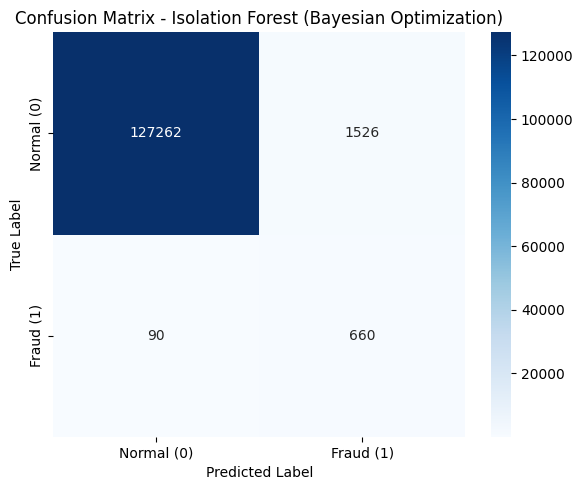

In [73]:
# Predicted values and true values for confusion matrix for Optuna (Bayesian Optimization)
y_true = y_test
y_pred_optuna = (best_pipeline.predict(X_test) == -1).astype(int)

# Build confusion matrix
cm_optuna = confusion_matrix(y_true, y_pred_optuna)
labels = ['Normal (0)', 'Fraud (1)']

# plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_optuna, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix - Isolation Forest (Bayesian Optimization)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [74]:
metrics = {
    "Method": ["Optuna"],
    "Precision": [
        precision_score(y_test, y_pred_optuna)
    ],
    "Recall": [
        recall_score(y_test, y_pred_optuna)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred_optuna)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_pred_optuna)
    ],
    "Cohen Kappa": [
        cohen_kappa_score(y_test, y_pred_optuna)
    ]
}

df_metrics = pd.DataFrame(metrics)
display(df_metrics)

,Method,Precision,Recall,F1-Score,ROC-AUC,Cohen Kappa
0,Optuna,0.301921,0.88,0.449591,0.934076,0.444805


ROC Curve

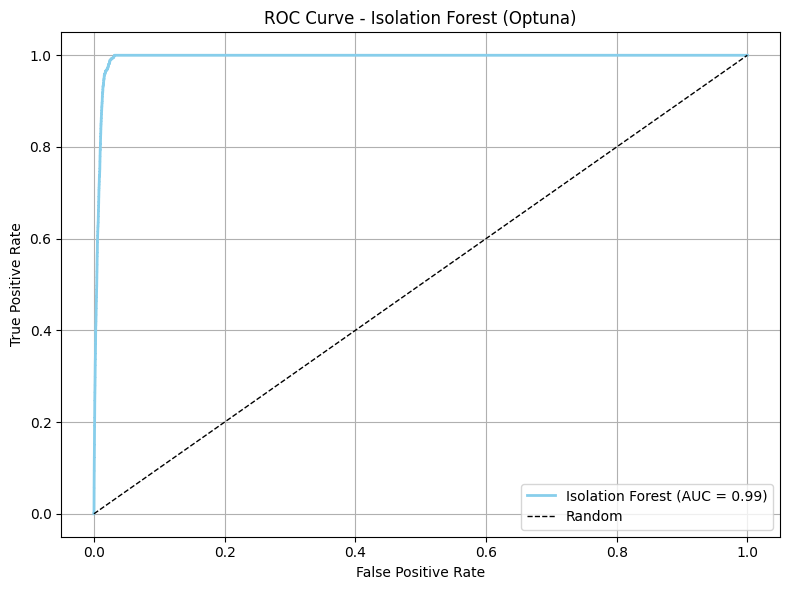

In [75]:
# --- Display ROC Curve ---
y_score = best_pipeline.decision_function(X_test)

# Build ROC curve
fpr, tpr, thresholds = roc_curve(y_test, -y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='skyblue', lw=2, label=f'Isolation Forest (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Isolation Forest (Optuna)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

Precision-Recall Curve

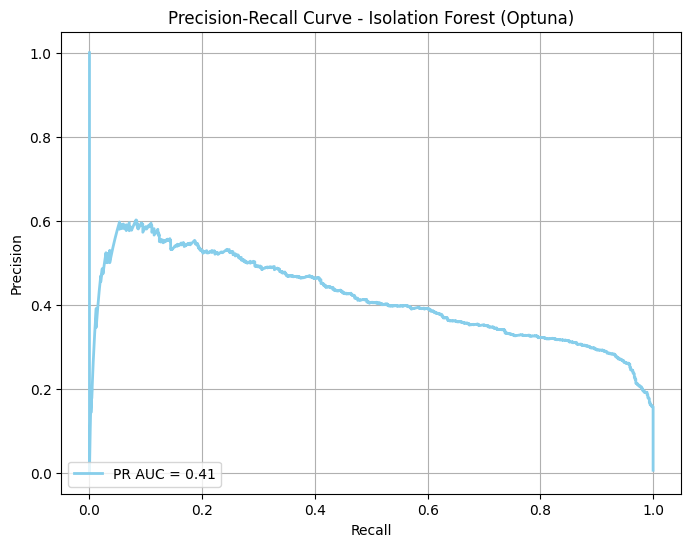

In [ ]:
# --- Display Precision-Recall Curve ---
y_score = best_pipeline.decision_function(X_test)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, -y_score)
pr_auc = average_precision_score(y_test, -y_score)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='skyblue', lw=2, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Isolation Forest (Optuna)')
plt.legend(loc='lower left')
plt.grid(True)

Metrics Comparison

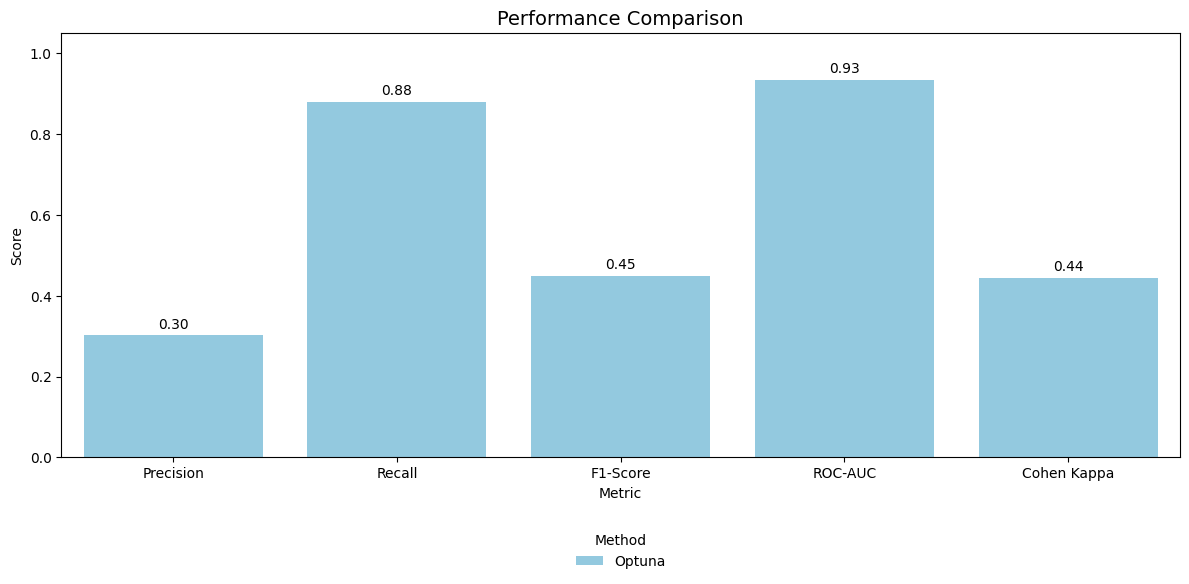

In [77]:
# --- Display Metrics Comparison ---
plt.figure(figsize=(12, 6))

df_melt = df_metrics.melt(id_vars="Method", var_name="Metric", value_name="Score")
ax = sns.barplot(data=df_melt, x="Metric", y="Score", hue="Method", palette=["skyblue"])

# Annotate the bars with their values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.2f}',
            ha="center", va="bottom"
        )

plt.title("Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.legend(
    title="Method",
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)
plt.tight_layout()
plt.grid(False)
plt.show()

Overfitting Plot

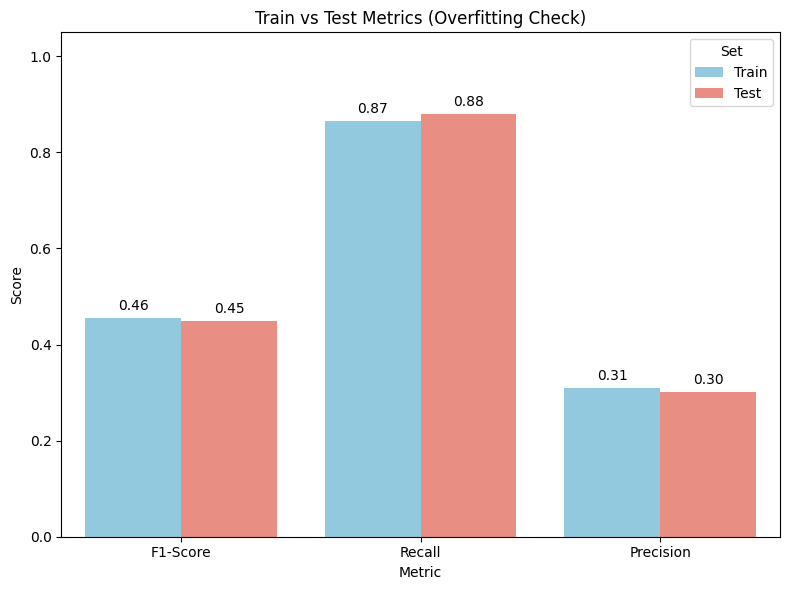

In [78]:
# --- Calculate metrics for train set ---
y_pred_train = (best_pipeline.predict(X_trainval) == -1).astype(int)
train_f1 = f1_score(y_trainval, y_pred_train)
train_recall = recall_score(y_trainval, y_pred_train)
train_precision = precision_score(y_trainval, y_pred_train)

# --- Calculate metrics for test set ---
y_pred_test = (best_pipeline.predict(X_test) == -1).astype(int)
test_f1 = f1_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test)

# --- Prepare DataFrame for plotting ---
df_overfit = pd.DataFrame({
    "Metric": ["F1-Score", "Recall", "Precision"],
    "Train": [train_f1, train_recall, train_precision],
    "Test": [test_f1, test_recall, test_precision]
})

df_overfit = df_overfit.melt(id_vars="Metric", var_name="Set", value_name="Score")

# --- Plot ---
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_overfit, x="Metric", y="Score", hue="Set", palette=["skyblue", "salmon"])
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height):
        ax.text(
            p.get_x() + p.get_width() / 2.,
            height + 0.01,
            f'{height:.2f}',
            ha="center", va="bottom"
        )
plt.title("Train vs Test Metrics (Overfitting Check)")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.tight_layout()
plt.grid(False)
plt.show()

### 2.3 Save Model

In [79]:
# 1. Save full pipeline with all preprocessing steps (Precision-optimized)
full_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('select_kbest', SelectKBest(score_func=f_classif, k=15)),  # เพิ่มเป็น 15
    ('pca', PCA(n_components=8)),  # เพิ่มเป็น 8
    ('isolation_forest', IsolationForest(**best_params, random_state=42))
])

# Prepare data for fitting
X = df_all.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'dob', 'is_fraud'], axis=1)
y = df_all['is_fraud']

# Fit and save pipeline
full_pipeline.fit(X, y)
joblib.dump(full_pipeline, "full_pipeline_isolation_forest_general_split.joblib")

# 2. Save best parameters
with open("params_IsolationForest_fromOptuna_general_split.json", "w") as f:
    json.dump(best_params, f)

# 3. Save model with parameters
save_dict = {
    "pipeline": full_pipeline,
    "params": best_params
}
joblib.dump(save_dict, "IsolationForest_with_params_general_split.joblib")

['IsolationForest_with_params_general_split.joblib']

# Model Testing

In [80]:
df = pd.read_csv("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/data/fraudTest_cleaned.csv", index_col=0)
loaded_pipeline = joblib.load("/Users/thanyalak/Desktop/y_lims/DADS4/9000_IS_FraudDetection/repos/Credit_Card_Fraud_Detection/ml_training/single_sequential_version/models/AnomalyDetection/general_split/full_pipeline_isolation_forest_general_split.joblib")

In [81]:
# Random sample for testing
# sample_df = df.sample(n=50, random_state=42).copy()
sample_df = df.sample(100).copy()
X_sample = sample_df.drop(['first', 'last', 'street', 'trans_date_trans_time', 'dob', 'trans_num', 'dob', 'is_fraud'], axis=1)

In [82]:
predictions = loaded_pipeline.predict(X_sample)
predicted_result = (predictions == -1).astype(int) # 1 = fraud, 0 = normal

In [83]:
# Calculate fraud probability (normalize anomaly score to 0-1)
anomaly_score = loaded_pipeline.decision_function(X_sample)
fraud_probability = (anomaly_score.max() - anomaly_score) / (anomaly_score.max() - anomaly_score.min())

# Add predictions and fraud probability to sample_df
sample_df['predicted_result'] = predicted_result
sample_df['fraud_probability'] = fraud_probability

# Select columns to display
columns_to_show = [
    'trans_date_trans_time', 'trans_num', 'cc_num',  'first', 'last', 'merchant', 'amt',
    'is_fraud', 'predicted_result', 'fraud_probability'
]
display(sample_df[columns_to_show].reset_index(drop=True))

,trans_date_trans_time,trans_num,cc_num,first,last,merchant,amt,is_fraud,predicted_result,fraud_probability
0,2020-10-18 19:04:11,686f53426732240dc07b6b61e24f024d,581686439828,Larry,House,400,53.26,0,0,0.042742
1,2020-12-07 06:44:40,b0d8cd95e5b33d7cb822d43206eda698,568279015842,Micheal,Hernandez,443,102.74,0,0,0.549420
2,2020-10-12 14:31:40,c355757751e29a4cf85176e9f9568b7a,6011367958204270,Tammy,Ayers,22,65.88,0,0,0.098352
3,2020-12-01 01:00:54,c8c5bb4d8d17c92b13d436893a6c34c6,3529597810116815,Pamela,Curtis,475,5.30,0,0,0.365718
4,2020-09-01 00:44:05,9248086a58506a7f0e56ee2243d3d444,6011148190095209,Terri,Bailey,534,40.97,0,0,0.103099
...,...,...,...,...,...,...,...,...,...,...
95,2020-08-18 11:41:28,bf30b62ce2c85b4e1fa36654eca2bc04,3553629419254918,Sharon,Johnson,336,68.58,0,0,0.484414
96,2020-07-11 22:00:50,158d598056ec29b4aa90f5a6bdde47a8,3546674063249004,Jordan,May,482,27.13,0,0,0.653193
97,2020-07-31 03:37:39,1323b9554a4125fb4f0f487aa36d36d4,4099707841315751,James,Stephens,47,52.65,0,0,0.049613
98,2020-12-30 14:49:48,e7cc7a2df94f66ebe557d92bca884f69,213113028819344,Melanie,Jimenez,192,29.88,0,0,0.606483
